In [65]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

# DDS vs "TrueARB" waveform synthesis

## Basics of digital waveform generators

In both cases, we start with an "ideal" waveform that the user can specify that is a digital representation of the signal we want to generate. 

In both cases, this is loaded into a "memory register" of the instrument. The instrument is then equipped with a clock, and at every "tick" of the clock it outputs a bit of the waveform. 

In both cases, a waveform generator will specify a "sampling rate", specified in "samples per second": for example, a generator with a "100 MSa/s" sampling rate has digital electronics that can "clock out" 100 million points of a waveform per second, or equivalently, one "bit" of the input waveform every 10 ns:

In [9]:
SR = 100e6 # samples / sec
print("A sample rate of %.1f MSa/s give a time spacing of %.1f ns per sample point" %
     (SR/1e6, 1/SR*1e9))

A sample rate of 100.0 MSa/s give a time spacing of 10.0 ns per sample point


In principle, 100 MSa/s would imply a Nyquist freuqency of 50 MHz. However, that does not mean that every instrument with 100 MSa/s can generate a 50 MHz frequency, since the performance of the generator also depends on the performance of the "analogue" RF output stages of the generator. Rigol, for example, sells 10 MHz, 20 MHz, and 35 MHz models of their 125 MSa/s generators. Specifically, this "analogue bandwidth" is defined by 3 dB point of the rolloff of the amplitude of a sine wave that the machine can generate. This is also linked to the "rise time" of the analog output stage of the instrument, which can be longer than the sample point spacing: for example, a 100 MHz generator with a 10 MHz 3 dB point would have a rise time of:

In [10]:
BW = 10e6 # Hz
tau = 1/2/np.pi/BW
print("A bandwidht of %.2f MHz corresponds to a ries time of %d ns" % (BW/1e6, tau*1e9))

A bandwidht of 10.00 MHz corresponds to a ries time of 15 ns


Note that a sampling rate that is much smaller than your rise time is still useful: for example, a 1 ns sampling rate with a 10 ns rise time would still allow you to create relative *shifts* of two pulses with a controllability of 1 ns. Similarly, the smaller the sampling rate, the high the precision with which one can specify the phase of two lower-frequency generated sine waves. 

As a basic illustrative example, if I have a 100 MSa/s generator, I could make a sine wave for example, by uploading the following waveform and outputting this directly point-by-point at 100 MSa/s:

Text(0.5, 0, 'Memory index')

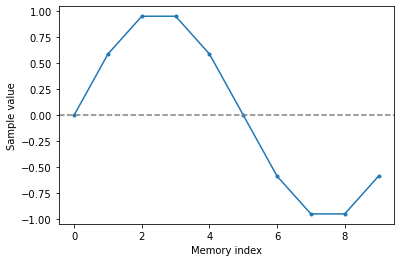

In [80]:
n = np.array(range(10))
wfm = np.sin(2*np.pi*n/10)
plt.plot(n,wfm, '.-')
plt.axhline(ls="--", c='grey')
plt.ylabel("Sample value")
plt.xlabel("Memory index")

In both cases, this output from the digitial to analong converter (DAC) would look like this:

Text(0.5, 1.0, 'Output as single line')

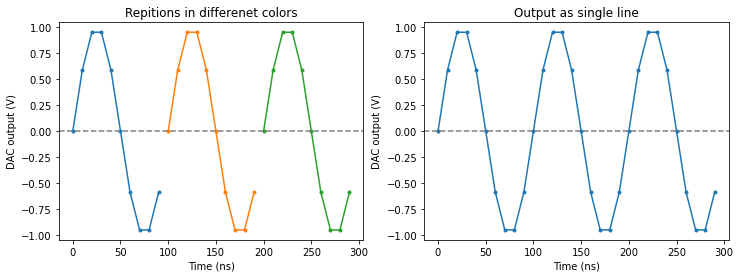

In [81]:
plt.figure(figsize=(12,4))

dt = 10 # nanoseconds = 1/(100MSa/s)
t=n*dt

# Separate line illustration 
plt.subplot(121)
for i in range(3):
    plt.plot(t+i*100,wfm, '.-')

plt.ylabel("DAC output (V)")
plt.xlabel("Time (ns)")
plt.axhline(ls="--", c='grey')
plt.title("Repitions in differenet colors")

# Continuous line illustration
plt.subplot(122)
t_c = []
wfm_c = []
for i in range(3):
    t_c = np.append(t_c, t+i*100)
    wfm_c = np.append(wfm_c, wfm)

plt.plot(t_c, wfm_c, '.-')
plt.ylabel("DAC output (V)")
plt.xlabel("Time (ns)")
plt.axhline(ls="--", c='grey')
plt.title("Output as single line")

With this waveform and this sampling rate, we end up with a sine wave with frequency:

In [82]:
print("Waveform frequency is %.1f MHz" % (1/100e-9/1e6))

Waveform frequency is 10.0 MHz


Using the scheme above, in which we output point ("sample") ] of the waveform in our memory, we could also make other frequencies by *changing* the waveform in the memory, specifically, by making the memory trace length $N$ longer, For example, this would be 5 MHz:

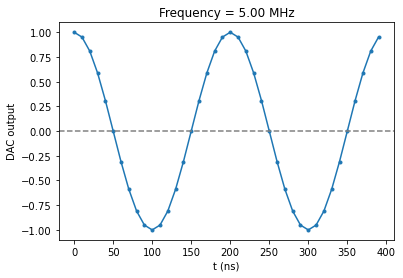

In [83]:
# Change to a cosine because the sine-wave gives zero output 
# when set to the nyquist frequency...

dt = 10 # nanoseconds = 1/(100MSa/s)
def plot_cos(N):
    n = np.array(range(N))
    wfm = np.cos(2*np.pi*n/N)
    t = n*dt
    plt.plot(np.append(t,t+N*10),np.append(wfm,wfm), '.-')
    plt.axhline(ls="--", c='grey')
    plt.ylabel("DAC output")
    plt.xlabel("t (ns)")
    plt.title("Frequency = %.2f MHz" % (100/N))
    plt.ylim(-1.1,1.1)

plot_sine(20)

Using this, however, we can only generate sub-multiples of the sampling frequency:

In [84]:
def update_plot(n=20):
    plot_cos(n)

interact(update_plot, n=(2,50));

interactive(children=(IntSlider(value=20, description='n', max=50, min=2), Output()), _dom_classes=('widget-in…

Another disadvantage is that if we want to use this, for example, as a sine-wave generator, then every time we want to change the frequency of the signal we output, we need to upload a new waveform. 

## Changing frequency without uploading waveform

Say we want to change the frequency *without* changing the waveform in memory? 

This is where TrueARB and DDS differ in their strategy: 

*  **TrueARB** changes the "clock" rate of the DAC to change the sample rate (change  `dt`)

* **DDS** keeps the clock rate fixed and "repeats" points to make lower frequencies, with the choice of how many times it repeats a given point chosen to get the correct average frequency in the output. 

The TrueARB approach is an "analogue" solution: it requires you to be able to generate different "analogue" clock frequencies to feed into your DAC. (Typically this is actually done with DDS...).

DDS is a simpler (and cheaper) "digital" solution: you have a single fixed fixed clock of your DAC, and you implement the change of the frequency of the output using digital tricks. 

## TrueARB example

As an example, let's start with the 5 MHz example above:

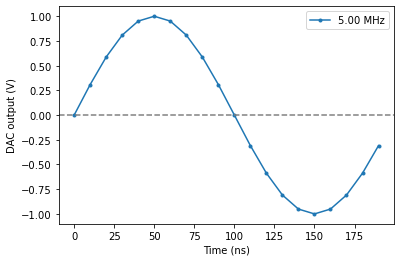

In [109]:
N = 20
def plot_dt(dt):
    n = np.array(range(N))
    wfm = np.sin(2*np.pi*n/N)
    t=n*dt
    plt.plot(t, wfm, '.-', label = "%.2f MHz" % (1/dt/N/1e-9/1e6))
    plt.ylabel("DAC output (V)")
    plt.xlabel("Time (ns)")
    plt.axhline(ls="--", c='grey')
    plt.legend()
    
plot_dt(10)

Using TrueARB, to make this 2.5 MHz, we just change the clock of our DAC so that `dt` is 20 ns:

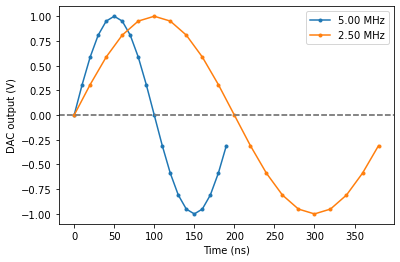

In [110]:
plot_dt(10)
plot_dt(20)

Since the DAC clock can be configured continuously, we can also generate any arbitrary frequency, not just sub-multiples:

dt is 11.0375 ns


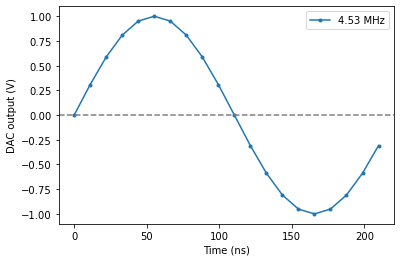

In [112]:
f = 4.53e6
dt = 1/f/N
print("dt is %.4f ns" % (dt*1e9))
plot_dt(dt*1e9)

## DDS example

In DDS, we always output points at the same sample rate, but output points multiple times to get the correct frequency. 

If the frequency is a submultiple of the sampling frequency, ie. `fs/n` where `n` is an integer, then this is easy: we just repeat each point `n` times. 

If our target frequency is an integer sub-multiple of our sampling frequency, this is easy and deterministic. For example, to generate a 3.33 MHz (10/3) signal from the above example, we just repeat the point three times:

Text(0.5, 1.0, 'DDS at 1/3 of sampling rate')

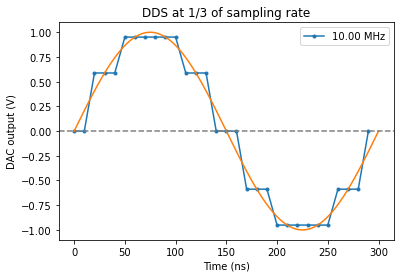

In [145]:
N = 10
n = np.array(range(N))
wfm = np.sin(2*np.pi*n/N)
dt = 10 # ns
t = n*dt

# A bit of a hack, you may need to think about it for a while
n_dds = np.array(range(N*3))
ind_dds = np.round(np.array(range(N*3))/3).astype('int')%10
t_dds = n_dds * dt
wfm_dds = wfm[ind_dds]

plt.plot(t_dds, wfm_dds, '.-', label = "%.2f MHz" % (1/dt/N/1e-9/1e6))
t_cont = np.linspace(0,300,500)
plt.plot(t_cont, np.sin(2*np.pi*t_cont/300))
plt.ylabel("DAC output (V)")
plt.xlabel("Time (ns)")
plt.axhline(ls="--", c='grey')
plt.legend()
plt.title("DDS at 1/3 of sampling rate")

What about if the target frequency  is *not* a sub-multiple of the sample rate? In that case, DDS chooses sometimes to skip a point, and sometimes not, and does so in such a way that the average frequency of the signal is correct.

For example, in the above a 10 MHz sine wave is created by outputting the 10 points of the signal on each run through the waveform in memory. 

But let's say wanted a 9.0909... MHz signal (10/1.1 MHz). This we could achieve if we skipped one point every second run. On average, the waveform would *nearly* look like a signal of the correct frequency, but with periodically repeating errors every so often. This is exactly the approach that DDS takes,  and this is 

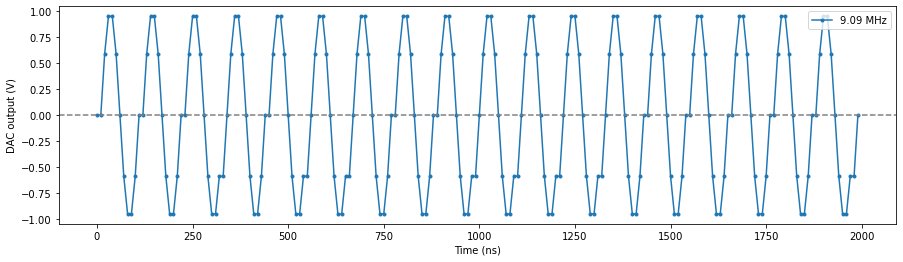

In [243]:
def plot_dds(f):
    N = 10
    n = np.array(range(N))
    wfm = np.sin(2*np.pi*n/N)
    dt = 10 # ns
    t = n*dt

    # A nice hack that we will use later in a fancier way:)
    N_pts = N*20
    n_dds = np.array(range(N_pts))
    ind_dds = (n_dds/f//1%N).astype('int')

    t_dds = n_dds * dt
    wfm_dds = wfm[ind_dds]

    plt.figure(figsize=(15,4))
    plt.plot(t_dds, wfm_dds, '.-', label = "%.2f MHz" % (1/dt/N/1e-9/1e6/f))
    plt.ylabel("DAC output (V)")
    plt.xlabel("Time (ns)")
    plt.axhline(ls="--", c='grey')
    plt.legend()

plot_dds(1.1)

This produces the correct frequency, but with random bit errors every so often so that the average frequency is correct. 

In [244]:
def update_plot(f=1):
    plot_dds(f)
    
interact(update_plot, f=(0.5,4,0.05));

interactive(children=(FloatSlider(value=1.0, description='f', max=4.0, min=0.5, step=0.05), Output()), _dom_cl…